## Setup the environment

#### Adding the source code path

In [1]:
import sys  
sys.path.insert(1, "./../../../../ESN-IP/SOURCES/.")

In [2]:
import random

random.seed(10)

In [3]:
from DATA import UNIFORM 
import numpy as np
import matplotlib.pyplot as plt

 ## Checking the Random Timeseries Generation 

Samples are randomly sampled from a uniform distribution, by defaut between [-0.5, 0.5], but such bound can be redefined. 
The resulting timeseries is then delayde by $\tau$ steps,

In [4]:
data = UNIFORM()
data.delay_timeseries(10)

X = data.X_DATA
Y = data.Y_DATA

In [5]:
size = X.shape[0]
print(X.shape, Y.shape)

torch.Size([6000]) torch.Size([6000])


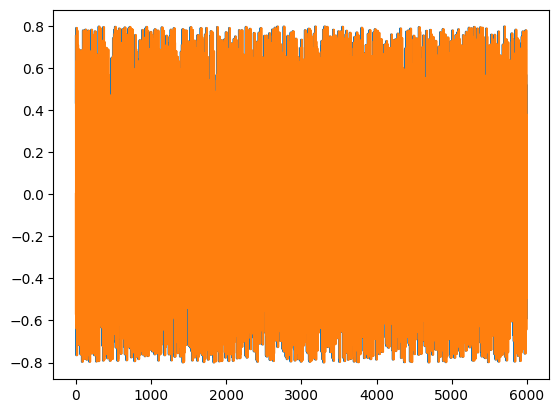

In [6]:
t = np.arange(0,size)
plt.plot(t, X, t, Y)
plt.show()

## Brute implementation

In [30]:
import torch

In [8]:
from Reservoir import Reservoir
from ESN import  EchoStateNetwork

In [32]:
reservoir_units = 10
max_delay = 2 * reservoir_units
    
# initialise reservoir here
model = EchoStateNetwork(Reservoir(N = reservoir_units, ro_rescale=0.95))
   
MC = np.zeros(max_delay+1)
for k in range(1,max_delay+1): # k is the delay

    # ############# generate random uniform time series data ############### #
    length = 6000
    time_series = np.random.uniform(-0.8, 0.8, length+k) 
    X_data = np.zeros(length)
    X_data = time_series[k:length+k]

    train_length = 5000
    trX = X_data[:train_length]
    input_train = trX[:train_length]
    test_length = 1000
    tsX = X_data[train_length:]
    input_test = tsX[:test_length]

    target_train = time_series[:train_length]
    target_test = time_series[train_length:-k]
    # ###################################################################### #

    # fit readout here
    train_predicted = model.train(torch.Tensor(input_train), torch.Tensor(target_train), 0, verbose=False)
        
    # predict the output here
    test_pred = model.predict(torch.Tensor(input_test)).numpy()

    # #################  MC_k calculation for the given k ################ #
    target_mean = np.mean(target_test)
    output_mean = np.mean(test_pred) 
    num, denom_t, denom_out = 0, 0, 0
    for i in range(test_length):
        deviat_t = target_test[i] - target_mean
        deviat_out = test_pred[i] - output_mean
        num += deviat_t * deviat_out
        denom_t += deviat_t**2
        denom_out += deviat_out**2
    num = num**2
    den = denom_t * denom_out
    MC[k] = num/den
    # #################################################################### #

final_MC = sum(MC)

In [33]:
final_MC

4.048824729647864

## Checking the Memory Capacity variation as the number of units changes


In [37]:
from Metrics import MC

def mean_mc(res: Reservoir, repetitions: int):
    mc = 0
    for _ in range(repetitions):
        mc += MC().evaluate(res)

    return mc/repetitions

In [38]:
res_5 = Reservoir(N = 5, ro_rescale=0.95)
res_10 = Reservoir(N = 10, ro_rescale=0.95)
res_25 = Reservoir(N = 25, ro_rescale=0.95)


In [39]:
mean_mc(res_5, 5)

tensor(3.3230)

In [41]:
mean_mc(res_10, 5)

tensor(5.2916)

In [42]:
mean_mc(res_25, 5)

tensor(6.2973)

## Increased MC of Identity ESN 

In [43]:
id_res_5 = Reservoir(N = 5, ro_rescale=0.95, activation=torch.nn.Identity())
id_res_10 = Reservoir(N = 10, ro_rescale=0.95, activation=torch.nn.Identity())
id_res_25 = Reservoir(N = 25, ro_rescale=0.95, activation=torch.nn.Identity())


In [44]:
mean_mc(id_res_5, 5)

tensor(4.1461)

In [45]:
mean_mc(id_res_10, 5)

tensor(9.6115)

In [46]:
mean_mc(id_res_25, 5)

tensor(21.5992)